# Notebook to recover spike waveform from notch filter oscillations

## Imports

In [46]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
from mosquito.analyze_bursts import realign_spikes
from mosquito.util import iir_notch_filter, butter_highpass_filter, butter_bandpass_filter


## Params

In [34]:
# plotting preferences
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Load data 

In [302]:
# which data set to load
data_folder = '23_20240517'  #  '24_20240520'  # '28_20240529'  #   '29_20240530'
axo_num = 6  # 8  #  7  # 

# load
data = load_processed_data(data_folder, axo_num)


In [303]:
# read from dictionary
spike_idx = data['spike_idx']
spikes = data['spikes']
emg = data['emg']
t = data['time']
window = round(data['params']['emg_window']/2)
fs = data['sampling_freq'] 
wbf = data['wbf']

## Realign spikes and visualize
(try to get a sense for notch oscillation frequency)

In [304]:
# try another filtering of data
emg_filt_new = butter_bandpass_filter(emg, np.floor(np.min(wbf)), np.ceil(np.max(wbf)), 1/fs, btype='stop', order=5) 
# emg_highpass = butter_highpass_filter(emg_filt_new, 200, 1/fs, order=8)
emg_highpass = butter_bandpass_filter(emg_filt_new, 200, 800, 1/fs, order=15)

# emg_filt_new = iir_notch_filter(emg, 459, 1/fs) 

In [305]:
# realign
spikes_realigned_raw, realigned_idx = realign_spikes(spikes, spike_idx, emg, window, thresh_factor=0.25)

# realign filtered
spikes_realigned_new = list()
for ridx in realigned_idx:
    slice_curr = slice(ridx - window, ridx + 2*window)
    spikes_realigned_new.append(emg_highpass[slice_curr])

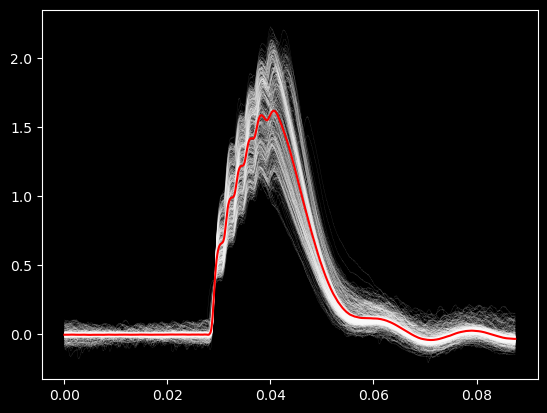

In [306]:
# visualize
spikes_array = np.vstack(spikes_realigned_raw)
spikes_array -= np.reshape(np.mean(spikes_array[:, :window], axis=1), (-1, 1))
# spikes_array -= np.reshape(spikes_array[:,0], (-1, 1))

spike_t = (1/fs)*np.arange(spikes_array[0].size)

fig, ax = plt.subplots()

for spike in spikes_array:
    ax.plot(spike_t, spike, lw=0.2, alpha=0.2, color='w')

ax.plot(spike_t, np.mean(spikes_array, axis=0), 'r-')

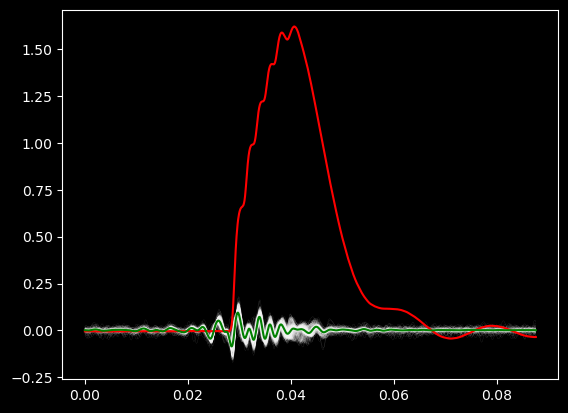

In [307]:
# visualize
spikes_array_new = np.vstack(spikes_realigned_new)
spikes_array_new -= np.reshape(np.mean(spikes_array_new[:, :window], axis=1), (-1, 1))
# spikes_array -= np.reshape(spikes_array[:,0], (-1, 1))

spike_t = (1/fs)*np.arange(spikes_array_new[0].size)

fig, ax = plt.subplots()

for spike in spikes_array_new:
    ax.plot(spike_t, spike, lw=0.2, alpha=0.2, color='w')

ax.plot(spike_t, np.mean(spikes_array, axis=0), 'r-')
ax.plot(spike_t, np.mean(spikes_array_new, axis=0), 'g-')

# ax.set_xlim([0.028, 0.05])

In [308]:
spikes_array.shape

(552, 3072)

In [309]:
# fig, ax = plt.subplots(figsize=(11,4))

# ax.plot(spike_t, np.mean(spikes_array, axis=0) - np.mean(spikes_array_new, axis=0))

# ax1 = plt.twinx()
# ax1.plot(spike_t, np.mean(spikes_array, axis=0), color='r')


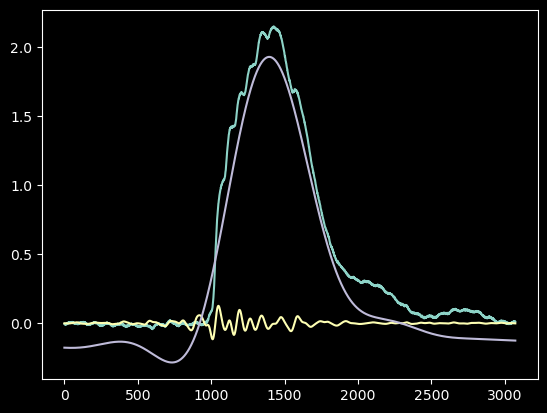

In [310]:
plt.plot(spikes_array[23, :])
plt.plot(spikes_array_new[23, :])

idx_tmp = slice(realigned_idx[23] - window, realigned_idx[23] + 2*window)
plt.plot(data['emg_filt'][idx_tmp])
# plt.plot(iir_notch_filter(spikes_array[76, :], 459, 1/fs))


In [301]:
print(np.mean(data['wbf']))
print(data['wbf_mean'])
curr_slice = slice(spike_idx[76]-500, spike_idx[76]+500)
print(np.mean(data['wbf'][curr_slice]))

431.963506609894
432.1273394098903
432.59618223138153


## Try to use in silico notch filter

-0.14287783394596018


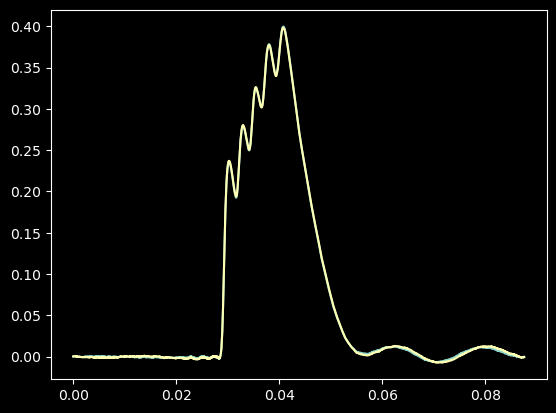

In [108]:
# try filtering mean
spike_mean =  np.mean(spikes_array, axis=0)
spike_mean_filt =  butter_bandpass_filter(spike_mean, 59, 61, 1/fs, btype='stop', order=5)  #iir_notch_filter(spike_mean, 30, 1/fs, Q=100)  #  

fig, ax = plt.subplots()
ax.plot(spike_t, spike_mean)
ax.plot(spike_t, spike_mean_filt)

print(np.sum(spike_mean - spike_mean_filt))

## Try empirical mode decomposition

In [53]:
!pip install emd

/bin/bash: /home/sam/.local/bin/pip: /snap/blender/4115/3.3/python/bin/python3.10: bad interpreter: No such file or directory
